In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
import matplotlib.pyplot as plt


data = scipy.io.loadmat("spam_data.mat")
names = [x[0] for x in data['names'][:,1:].ravel()]
X_train = data['P_train'].transpose().astype("float")
X_test = data['P_test'].transpose().astype("float")
y_train = (data['T_train'].transpose().ravel() + 1)/2
y_test = (data['T_test'].transpose().ravel() + 1)/2
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

"""Hyper-parameters"""
batch_size = 380            # Batch size for stochastic gradient descent
test_size = batch_size      # Temporary heuristic. In future we'd like to decouple testing from batching
num_centr = 100             # Number of "hidden neurons" that is number of centroids
max_iterations = 10000       # Max number of iterations
learning_rate = 5e-2        # Learning rate
num_classes = 2            # Number of target classes, 10 for MNIST
var_rbf = 225               # What variance do you expect workable for the RBF?

#Obtain and proclaim sizes
N,D = X_train.shape         
Ntest = X_test.shape[0]
print('We have %s observations with %s dimensions'%(N,D))

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

#Placeholders for data
x = tf.placeholder('float',shape=[batch_size,D],name='input_data')
y_ = tf.placeholder(tf.int64, shape=[batch_size], name = 'Ground_truth')


with tf.name_scope("Hidden_layer") as scope:
  #Centroids and var are the main trainable parameters of the first layer
  centroids = tf.Variable(tf.random_uniform([num_centr,D],dtype=tf.float32),name='centroids')
  var = tf.Variable(tf.truncated_normal([num_centr],mean=var_rbf,stddev=5,dtype=tf.float32),name='RBF_variance')
  
  #For now, we collect the distanc
  exp_list = []
  for i in range(num_centr):
        exp_list.append(tf.exp((-1*tf.reduce_sum(tf.square(tf.subtract(x,centroids[i,:])),1))/(2*var[i])))
        phi = tf.transpose(tf.stack(exp_list))
        
with tf.name_scope("Output_layer") as scope:
    w = tf.Variable(tf.truncated_normal([num_centr,num_classes], stddev=0.1, dtype=tf.float32),name='weight')
    bias = tf.Variable( tf.constant(0.1, shape=[num_classes]),name='bias')
        
    h = tf.matmul(phi,w)+bias
    size2 = tf.shape(h)

with tf.name_scope("Softmax") as scope:
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h,labels=y_)
  cost = tf.reduce_sum(loss)
  loss_summ = tf.summary.scalar("cross_entropy_loss", cost)

with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
#     The following block plots for every trainable variable
#      - Histogram of the entries of the Tensor
#      - Histogram of the gradient over the Tensor
#      - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient
      
      numel +=tf.reduce_sum(tf.size(variable))  
        
      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating") as scope:
    correct_prediction = tf.equal(tf.argmax(h,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
   
merged = tf.summary.merge_all()


# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /50))))

with tf.Session() as sess:
  with tf.device("/cpu:0"):
    print('Start session')
    writer = tf.summary.FileWriter("/Users/marcosdiniz/Documents/UnB/FSI/projeto4/tensorflow", graph=sess.graph)

    step = 0
    sess.run(tf.global_variables_initializer())
    
#    #Debugging
#    batch_ind = np.random.choice(N,batch_size,replace=False)
#    result = sess.run([phi],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
#    print(result[0])
    
    
    for i in range(max_iterations):
      batch_ind = np.random.choice(N,batch_size,replace=False)
      if i%50 == 0:
        #Measure train performance
        result = sess.run([cost,accuracy,train_step],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
        perf_collect[0,step] = result[0]
        perf_collect[2,step] = result[1]
        
        
        #Measure test performance
        test_ind = np.random.choice(Ntest,test_size,replace=False)
        result = sess.run([cost,accuracy,merged], feed_dict={ x: X_test[test_ind], y_: y_test[test_ind]})
        perf_collect[1,step] = result[0]
        perf_collect[3,step] = result[1]
      
        #Write information for Tensorboard
        summary_str = result[2]
        writer.add_summary(summary_str, i)
        writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
        
        #Print intermediate numbers to terminal
        acc = result[1]
        print("Estimated accuracy at iteration %s of %s: %s" % (i,max_iterations, acc))
        step += 1
      else:
        sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
        
"""Additional plots"""
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()

# We can now open TensorBoard. Run the following line from your terminal
# tensorboard --logdir=/home/rob/Dropbox/ml_projects/RBFN_tf/log_tb

We have 3681 observations with 57 dimensions
Train with approximately 1032 epochs
Start session
Estimated accuracy at iteration 0 of 10000: 0.5947368
Estimated accuracy at iteration 50 of 10000: 0.63684213
Estimated accuracy at iteration 100 of 10000: 0.6394737
Estimated accuracy at iteration 150 of 10000: 0.6657895
Estimated accuracy at iteration 200 of 10000: 0.6394737
Estimated accuracy at iteration 250 of 10000: 0.6289474
Estimated accuracy at iteration 300 of 10000: 0.6263158
Estimated accuracy at iteration 350 of 10000: 0.5947368
Estimated accuracy at iteration 400 of 10000: 0.6289474
Estimated accuracy at iteration 450 of 10000: 0.6315789
Estimated accuracy at iteration 500 of 10000: 0.6552632
Estimated accuracy at iteration 550 of 10000: 0.6342105
Estimated accuracy at iteration 600 of 10000: 0.6631579
Estimated accuracy at iteration 650 of 10000: 0.63684213
Estimated accuracy at iteration 700 of 10000: 0.6447368
Estimated accuracy at iteration 750 of 10000: 0.6657895
Estimated

Estimated accuracy at iteration 7150 of 10000: 0.76842105
Estimated accuracy at iteration 7200 of 10000: 0.7894737
Estimated accuracy at iteration 7250 of 10000: 0.79210526
Estimated accuracy at iteration 7300 of 10000: 0.77105266
Estimated accuracy at iteration 7350 of 10000: 0.79210526
Estimated accuracy at iteration 7400 of 10000: 0.7842105
Estimated accuracy at iteration 7450 of 10000: 0.77105266
Estimated accuracy at iteration 7500 of 10000: 0.79210526
Estimated accuracy at iteration 7550 of 10000: 0.77894735
Estimated accuracy at iteration 7600 of 10000: 0.77105266
Estimated accuracy at iteration 7650 of 10000: 0.75
Estimated accuracy at iteration 7700 of 10000: 0.77894735
Estimated accuracy at iteration 7750 of 10000: 0.7842105
Estimated accuracy at iteration 7800 of 10000: 0.7842105
Estimated accuracy at iteration 7850 of 10000: 0.76842105
Estimated accuracy at iteration 7900 of 10000: 0.7526316
Estimated accuracy at iteration 7950 of 10000: 0.74473685
Estimated accuracy at ite

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

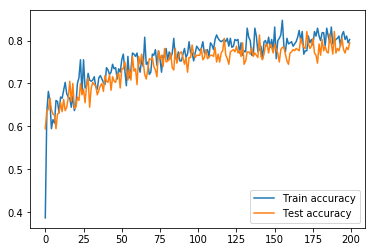

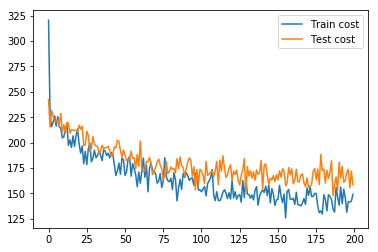

In [2]:
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()

In [6]:
min(perf_collect[3]), max(perf_collect[3]), sum(perf_collect[3])/len(perf_collect[3])

(0.5947368144989014, 0.821052610874176, 0.7434210535883904)

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
import matplotlib.pyplot as plt


data = scipy.io.loadmat("spam_data.mat")
names = [x[0] for x in data['names'][:,1:].ravel()]
X_train = data['P_train'].transpose().astype("float")
X_test = data['P_test'].transpose().astype("float")
y_train = (data['T_train'].transpose().ravel() + 1)/2
y_test = (data['T_test'].transpose().ravel() + 1)/2
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

"""Hyper-parameters"""
batch_size = 380            # Batch size for stochastic gradient descent
test_size = batch_size      # Temporary heuristic. In future we'd like to decouple testing from batching
num_centr = 100             # Number of "hidden neurons" that is number of centroids
max_iterations = 100000       # Max number of iterations
learning_rate = 5e-2        # Learning rate
num_classes = 2            # Number of target classes, 10 for MNIST
var_rbf = 225               # What variance do you expect workable for the RBF?

#Obtain and proclaim sizes
N,D = X_train.shape         
Ntest = X_test.shape[0]
print('We have %s observations with %s dimensions'%(N,D))

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

#Placeholders for data
x = tf.placeholder('float',shape=[batch_size,D],name='input_data')
y_ = tf.placeholder(tf.int64, shape=[batch_size], name = 'Ground_truth')


with tf.name_scope("Hidden_layer") as scope:
  #Centroids and var are the main trainable parameters of the first layer
  centroids = tf.Variable(tf.random_uniform([num_centr,D],dtype=tf.float32),name='centroids')
  var = tf.Variable(tf.truncated_normal([num_centr],mean=var_rbf,stddev=5,dtype=tf.float32),name='RBF_variance')
  
  #For now, we collect the distanc
  exp_list = []
  for i in range(num_centr):
        exp_list.append(tf.exp((-1*tf.reduce_sum(tf.square(tf.subtract(x,centroids[i,:])),1))/(2*var[i])))
        phi = tf.transpose(tf.stack(exp_list))
        
with tf.name_scope("Output_layer") as scope:
    w = tf.Variable(tf.truncated_normal([num_centr,num_classes], stddev=0.1, dtype=tf.float32),name='weight')
    bias = tf.Variable( tf.constant(0.1, shape=[num_classes]),name='bias')
        
    h = tf.matmul(phi,w)+bias
    size2 = tf.shape(h)

with tf.name_scope("Softmax") as scope:
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h,labels=y_)
  cost = tf.reduce_sum(loss)
  loss_summ = tf.summary.scalar("cross_entropy_loss", cost)

with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
#     The following block plots for every trainable variable
#      - Histogram of the entries of the Tensor
#      - Histogram of the gradient over the Tensor
#      - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient
      
      numel +=tf.reduce_sum(tf.size(variable))  
        
      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating") as scope:
    correct_prediction = tf.equal(tf.argmax(h,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
   
merged = tf.summary.merge_all()


# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /20))))

with tf.Session() as sess:
  with tf.device("/cpu:0"):
    print('Start session')
    writer = tf.summary.FileWriter("/Users/marcosdiniz/Documents/UnB/FSI/projeto4/tensorflow", graph=sess.graph)

    step = 0
    sess.run(tf.global_variables_initializer())
    
#    #Debugging
#    batch_ind = np.random.choice(N,batch_size,replace=False)
#    result = sess.run([phi],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
#    print(result[0])
    
    
    for i in range(max_iterations):
      batch_ind = np.random.choice(N,batch_size,replace=False)
      if i%20 == 0:
        #Measure train performance
        result = sess.run([cost,accuracy,train_step],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
        perf_collect[0,step] = result[0]
        perf_collect[2,step] = result[1]
        
        
        #Measure test performance
        test_ind = np.random.choice(Ntest,test_size,replace=False)
        result = sess.run([cost,accuracy,merged], feed_dict={ x: X_test[test_ind], y_: y_test[test_ind]})
        perf_collect[1,step] = result[0]
        perf_collect[3,step] = result[1]
      
        #Write information for Tensorboard
        summary_str = result[2]
        writer.add_summary(summary_str, i)
        writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
        
        #Print intermediate numbers to terminal
        acc = result[1]
        print("Estimated accuracy at iteration %s of %s: %s" % (i,max_iterations, acc))
        step += 1
      else:
        sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
        
"""Additional plots"""
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()

# We can now open TensorBoard. Run the following line from your terminal
# tensorboard --logdir=/home/rob/Dropbox/ml_projects/RBFN_tf/log_tb

We have 3681 observations with 57 dimensions
Train with approximately 10323 epochs
Start session
Estimated accuracy at iteration 0 of 100000: 0.5947368
Estimated accuracy at iteration 20 of 100000: 0.5710526
Estimated accuracy at iteration 40 of 100000: 0.60263157
Estimated accuracy at iteration 60 of 100000: 0.6
Estimated accuracy at iteration 80 of 100000: 0.5947368
Estimated accuracy at iteration 100 of 100000: 0.63684213
Estimated accuracy at iteration 120 of 100000: 0.6157895
Estimated accuracy at iteration 140 of 100000: 0.6210526
Estimated accuracy at iteration 160 of 100000: 0.60263157
Estimated accuracy at iteration 180 of 100000: 0.6263158
Estimated accuracy at iteration 200 of 100000: 0.6421053
Estimated accuracy at iteration 220 of 100000: 0.6315789
Estimated accuracy at iteration 240 of 100000: 0.6289474
Estimated accuracy at iteration 260 of 100000: 0.6631579
Estimated accuracy at iteration 280 of 100000: 0.64736843
Estimated accuracy at iteration 300 of 100000: 0.5894736

Estimated accuracy at iteration 2820 of 100000: 0.73157895
Estimated accuracy at iteration 2840 of 100000: 0.7157895
Estimated accuracy at iteration 2860 of 100000: 0.7131579
Estimated accuracy at iteration 2880 of 100000: 0.7157895
Estimated accuracy at iteration 2900 of 100000: 0.7394737
Estimated accuracy at iteration 2920 of 100000: 0.7157895
Estimated accuracy at iteration 2940 of 100000: 0.7131579
Estimated accuracy at iteration 2960 of 100000: 0.7131579
Estimated accuracy at iteration 2980 of 100000: 0.73157895
Estimated accuracy at iteration 3000 of 100000: 0.73157895
Estimated accuracy at iteration 3020 of 100000: 0.7473684
Estimated accuracy at iteration 3040 of 100000: 0.6868421
Estimated accuracy at iteration 3060 of 100000: 0.7157895
Estimated accuracy at iteration 3080 of 100000: 0.72105265
Estimated accuracy at iteration 3100 of 100000: 0.75
Estimated accuracy at iteration 3120 of 100000: 0.72894734
Estimated accuracy at iteration 3140 of 100000: 0.73421055
Estimated acc

Estimated accuracy at iteration 5660 of 100000: 0.77105266
Estimated accuracy at iteration 5680 of 100000: 0.7526316
Estimated accuracy at iteration 5700 of 100000: 0.75
Estimated accuracy at iteration 5720 of 100000: 0.7263158
Estimated accuracy at iteration 5740 of 100000: 0.75526315
Estimated accuracy at iteration 5760 of 100000: 0.75789475
Estimated accuracy at iteration 5780 of 100000: 0.7526316
Estimated accuracy at iteration 5800 of 100000: 0.79473686
Estimated accuracy at iteration 5820 of 100000: 0.7526316
Estimated accuracy at iteration 5840 of 100000: 0.74473685
Estimated accuracy at iteration 5860 of 100000: 0.76842105
Estimated accuracy at iteration 5880 of 100000: 0.72105265
Estimated accuracy at iteration 5900 of 100000: 0.75789475
Estimated accuracy at iteration 5920 of 100000: 0.7736842
Estimated accuracy at iteration 5940 of 100000: 0.77105266
Estimated accuracy at iteration 5960 of 100000: 0.7736842
Estimated accuracy at iteration 5980 of 100000: 0.7736842
Estimated 

Estimated accuracy at iteration 8520 of 100000: 0.7763158
Estimated accuracy at iteration 8540 of 100000: 0.77105266
Estimated accuracy at iteration 8560 of 100000: 0.79210526
Estimated accuracy at iteration 8580 of 100000: 0.7763158
Estimated accuracy at iteration 8600 of 100000: 0.74210525
Estimated accuracy at iteration 8620 of 100000: 0.76842105
Estimated accuracy at iteration 8640 of 100000: 0.7763158
Estimated accuracy at iteration 8660 of 100000: 0.7631579
Estimated accuracy at iteration 8680 of 100000: 0.77894735
Estimated accuracy at iteration 8700 of 100000: 0.7894737
Estimated accuracy at iteration 8720 of 100000: 0.7631579
Estimated accuracy at iteration 8740 of 100000: 0.76842105
Estimated accuracy at iteration 8760 of 100000: 0.76578945
Estimated accuracy at iteration 8780 of 100000: 0.7763158
Estimated accuracy at iteration 8800 of 100000: 0.7868421
Estimated accuracy at iteration 8820 of 100000: 0.7842105
Estimated accuracy at iteration 8840 of 100000: 0.7473684
Estimat

Estimated accuracy at iteration 11320 of 100000: 0.7526316
Estimated accuracy at iteration 11340 of 100000: 0.77894735
Estimated accuracy at iteration 11360 of 100000: 0.79473686
Estimated accuracy at iteration 11380 of 100000: 0.7736842
Estimated accuracy at iteration 11400 of 100000: 0.7605263
Estimated accuracy at iteration 11420 of 100000: 0.7763158
Estimated accuracy at iteration 11440 of 100000: 0.78157896
Estimated accuracy at iteration 11460 of 100000: 0.76842105
Estimated accuracy at iteration 11480 of 100000: 0.7736842
Estimated accuracy at iteration 11500 of 100000: 0.77894735
Estimated accuracy at iteration 11520 of 100000: 0.79473686
Estimated accuracy at iteration 11540 of 100000: 0.7868421
Estimated accuracy at iteration 11560 of 100000: 0.75789475
Estimated accuracy at iteration 11580 of 100000: 0.77894735
Estimated accuracy at iteration 11600 of 100000: 0.78157896
Estimated accuracy at iteration 11620 of 100000: 0.80263156
Estimated accuracy at iteration 11640 of 10000

Estimated accuracy at iteration 14080 of 100000: 0.7973684
Estimated accuracy at iteration 14100 of 100000: 0.7973684
Estimated accuracy at iteration 14120 of 100000: 0.7763158
Estimated accuracy at iteration 14140 of 100000: 0.8105263
Estimated accuracy at iteration 14160 of 100000: 0.7973684
Estimated accuracy at iteration 14180 of 100000: 0.7526316
Estimated accuracy at iteration 14200 of 100000: 0.79210526
Estimated accuracy at iteration 14220 of 100000: 0.76578945
Estimated accuracy at iteration 14240 of 100000: 0.7736842
Estimated accuracy at iteration 14260 of 100000: 0.77105266
Estimated accuracy at iteration 14280 of 100000: 0.7868421
Estimated accuracy at iteration 14300 of 100000: 0.7868421
Estimated accuracy at iteration 14320 of 100000: 0.80263156
Estimated accuracy at iteration 14340 of 100000: 0.76578945
Estimated accuracy at iteration 14360 of 100000: 0.81842107
Estimated accuracy at iteration 14380 of 100000: 0.7973684
Estimated accuracy at iteration 14400 of 100000: 0

Estimated accuracy at iteration 16880 of 100000: 0.77894735
Estimated accuracy at iteration 16900 of 100000: 0.8210526
Estimated accuracy at iteration 16920 of 100000: 0.79473686
Estimated accuracy at iteration 16940 of 100000: 0.7842105
Estimated accuracy at iteration 16960 of 100000: 0.79210526
Estimated accuracy at iteration 16980 of 100000: 0.8131579
Estimated accuracy at iteration 17000 of 100000: 0.7973684
Estimated accuracy at iteration 17020 of 100000: 0.78157896
Estimated accuracy at iteration 17040 of 100000: 0.7868421
Estimated accuracy at iteration 17060 of 100000: 0.79473686
Estimated accuracy at iteration 17080 of 100000: 0.81578946
Estimated accuracy at iteration 17100 of 100000: 0.7842105
Estimated accuracy at iteration 17120 of 100000: 0.78157896
Estimated accuracy at iteration 17140 of 100000: 0.7868421
Estimated accuracy at iteration 17160 of 100000: 0.81578946
Estimated accuracy at iteration 17180 of 100000: 0.77894735
Estimated accuracy at iteration 17200 of 100000

Estimated accuracy at iteration 19640 of 100000: 0.7868421
Estimated accuracy at iteration 19660 of 100000: 0.8131579
Estimated accuracy at iteration 19680 of 100000: 0.79210526
Estimated accuracy at iteration 19700 of 100000: 0.7973684
Estimated accuracy at iteration 19720 of 100000: 0.80263156
Estimated accuracy at iteration 19740 of 100000: 0.80263156
Estimated accuracy at iteration 19760 of 100000: 0.80526316
Estimated accuracy at iteration 19780 of 100000: 0.7605263
Estimated accuracy at iteration 19800 of 100000: 0.77105266
Estimated accuracy at iteration 19820 of 100000: 0.77894735
Estimated accuracy at iteration 19840 of 100000: 0.7842105
Estimated accuracy at iteration 19860 of 100000: 0.7842105
Estimated accuracy at iteration 19880 of 100000: 0.8210526
Estimated accuracy at iteration 19900 of 100000: 0.7868421
Estimated accuracy at iteration 19920 of 100000: 0.82631576
Estimated accuracy at iteration 19940 of 100000: 0.78157896
Estimated accuracy at iteration 19960 of 100000:

Estimated accuracy at iteration 22420 of 100000: 0.8105263
Estimated accuracy at iteration 22440 of 100000: 0.79210526
Estimated accuracy at iteration 22460 of 100000: 0.79473686
Estimated accuracy at iteration 22480 of 100000: 0.78157896
Estimated accuracy at iteration 22500 of 100000: 0.7763158
Estimated accuracy at iteration 22520 of 100000: 0.7894737
Estimated accuracy at iteration 22540 of 100000: 0.7973684
Estimated accuracy at iteration 22560 of 100000: 0.77894735
Estimated accuracy at iteration 22580 of 100000: 0.80263156
Estimated accuracy at iteration 22600 of 100000: 0.7894737
Estimated accuracy at iteration 22620 of 100000: 0.77894735
Estimated accuracy at iteration 22640 of 100000: 0.7868421
Estimated accuracy at iteration 22660 of 100000: 0.77894735
Estimated accuracy at iteration 22680 of 100000: 0.7842105
Estimated accuracy at iteration 22700 of 100000: 0.8210526
Estimated accuracy at iteration 22720 of 100000: 0.78157896
Estimated accuracy at iteration 22740 of 100000:

Estimated accuracy at iteration 25200 of 100000: 0.7842105
Estimated accuracy at iteration 25220 of 100000: 0.80263156
Estimated accuracy at iteration 25240 of 100000: 0.8
Estimated accuracy at iteration 25260 of 100000: 0.85263157
Estimated accuracy at iteration 25280 of 100000: 0.80789477
Estimated accuracy at iteration 25300 of 100000: 0.80263156
Estimated accuracy at iteration 25320 of 100000: 0.80789477
Estimated accuracy at iteration 25340 of 100000: 0.8105263
Estimated accuracy at iteration 25360 of 100000: 0.8105263
Estimated accuracy at iteration 25380 of 100000: 0.79473686
Estimated accuracy at iteration 25400 of 100000: 0.80789477
Estimated accuracy at iteration 25420 of 100000: 0.75
Estimated accuracy at iteration 25440 of 100000: 0.83947366
Estimated accuracy at iteration 25460 of 100000: 0.80263156
Estimated accuracy at iteration 25480 of 100000: 0.79473686
Estimated accuracy at iteration 25500 of 100000: 0.76842105
Estimated accuracy at iteration 25520 of 100000: 0.80789

Estimated accuracy at iteration 28000 of 100000: 0.80263156
Estimated accuracy at iteration 28020 of 100000: 0.8105263
Estimated accuracy at iteration 28040 of 100000: 0.8
Estimated accuracy at iteration 28060 of 100000: 0.80263156
Estimated accuracy at iteration 28080 of 100000: 0.80526316
Estimated accuracy at iteration 28100 of 100000: 0.80526316
Estimated accuracy at iteration 28120 of 100000: 0.80263156
Estimated accuracy at iteration 28140 of 100000: 0.7973684
Estimated accuracy at iteration 28160 of 100000: 0.80789477
Estimated accuracy at iteration 28180 of 100000: 0.79473686
Estimated accuracy at iteration 28200 of 100000: 0.80789477
Estimated accuracy at iteration 28220 of 100000: 0.82631576
Estimated accuracy at iteration 28240 of 100000: 0.7973684
Estimated accuracy at iteration 28260 of 100000: 0.7973684
Estimated accuracy at iteration 28280 of 100000: 0.79473686
Estimated accuracy at iteration 28300 of 100000: 0.81578946
Estimated accuracy at iteration 28320 of 100000: 0.

Estimated accuracy at iteration 30800 of 100000: 0.79473686
Estimated accuracy at iteration 30820 of 100000: 0.79473686
Estimated accuracy at iteration 30840 of 100000: 0.80526316
Estimated accuracy at iteration 30860 of 100000: 0.82894737
Estimated accuracy at iteration 30880 of 100000: 0.8131579
Estimated accuracy at iteration 30900 of 100000: 0.80526316
Estimated accuracy at iteration 30920 of 100000: 0.8210526
Estimated accuracy at iteration 30940 of 100000: 0.79473686
Estimated accuracy at iteration 30960 of 100000: 0.81842107
Estimated accuracy at iteration 30980 of 100000: 0.78157896
Estimated accuracy at iteration 31000 of 100000: 0.7894737
Estimated accuracy at iteration 31020 of 100000: 0.80526316
Estimated accuracy at iteration 31040 of 100000: 0.8
Estimated accuracy at iteration 31060 of 100000: 0.79473686
Estimated accuracy at iteration 31080 of 100000: 0.83947366
Estimated accuracy at iteration 31100 of 100000: 0.83157897
Estimated accuracy at iteration 31120 of 100000: 0

Estimated accuracy at iteration 33600 of 100000: 0.7868421
Estimated accuracy at iteration 33620 of 100000: 0.80526316
Estimated accuracy at iteration 33640 of 100000: 0.81842107
Estimated accuracy at iteration 33660 of 100000: 0.7842105
Estimated accuracy at iteration 33680 of 100000: 0.80789477
Estimated accuracy at iteration 33700 of 100000: 0.8131579
Estimated accuracy at iteration 33720 of 100000: 0.80789477
Estimated accuracy at iteration 33740 of 100000: 0.8210526
Estimated accuracy at iteration 33760 of 100000: 0.8105263
Estimated accuracy at iteration 33780 of 100000: 0.77105266
Estimated accuracy at iteration 33800 of 100000: 0.8210526
Estimated accuracy at iteration 33820 of 100000: 0.81842107
Estimated accuracy at iteration 33840 of 100000: 0.80526316
Estimated accuracy at iteration 33860 of 100000: 0.7894737
Estimated accuracy at iteration 33880 of 100000: 0.80263156
Estimated accuracy at iteration 33900 of 100000: 0.79210526
Estimated accuracy at iteration 33920 of 100000

Estimated accuracy at iteration 36380 of 100000: 0.8
Estimated accuracy at iteration 36400 of 100000: 0.80263156
Estimated accuracy at iteration 36420 of 100000: 0.8131579
Estimated accuracy at iteration 36440 of 100000: 0.7868421
Estimated accuracy at iteration 36460 of 100000: 0.82894737
Estimated accuracy at iteration 36480 of 100000: 0.82631576
Estimated accuracy at iteration 36500 of 100000: 0.81578946
Estimated accuracy at iteration 36520 of 100000: 0.7973684
Estimated accuracy at iteration 36540 of 100000: 0.8
Estimated accuracy at iteration 36560 of 100000: 0.79473686
Estimated accuracy at iteration 36580 of 100000: 0.80789477
Estimated accuracy at iteration 36600 of 100000: 0.81842107
Estimated accuracy at iteration 36620 of 100000: 0.81842107
Estimated accuracy at iteration 36640 of 100000: 0.81842107
Estimated accuracy at iteration 36660 of 100000: 0.8105263
Estimated accuracy at iteration 36680 of 100000: 0.8105263
Estimated accuracy at iteration 36700 of 100000: 0.7973684


Estimated accuracy at iteration 39180 of 100000: 0.8131579
Estimated accuracy at iteration 39200 of 100000: 0.8105263
Estimated accuracy at iteration 39220 of 100000: 0.8447368
Estimated accuracy at iteration 39240 of 100000: 0.77105266
Estimated accuracy at iteration 39260 of 100000: 0.8342105
Estimated accuracy at iteration 39280 of 100000: 0.81842107
Estimated accuracy at iteration 39300 of 100000: 0.81578946
Estimated accuracy at iteration 39320 of 100000: 0.8236842
Estimated accuracy at iteration 39340 of 100000: 0.80789477
Estimated accuracy at iteration 39360 of 100000: 0.8236842
Estimated accuracy at iteration 39380 of 100000: 0.80526316
Estimated accuracy at iteration 39400 of 100000: 0.81842107
Estimated accuracy at iteration 39420 of 100000: 0.8105263
Estimated accuracy at iteration 39440 of 100000: 0.80263156
Estimated accuracy at iteration 39460 of 100000: 0.8210526
Estimated accuracy at iteration 39480 of 100000: 0.80263156
Estimated accuracy at iteration 39500 of 100000:

Estimated accuracy at iteration 41960 of 100000: 0.8210526
Estimated accuracy at iteration 41980 of 100000: 0.7973684
Estimated accuracy at iteration 42000 of 100000: 0.81578946
Estimated accuracy at iteration 42020 of 100000: 0.8
Estimated accuracy at iteration 42040 of 100000: 0.7894737
Estimated accuracy at iteration 42060 of 100000: 0.83157897
Estimated accuracy at iteration 42080 of 100000: 0.7894737
Estimated accuracy at iteration 42100 of 100000: 0.8
Estimated accuracy at iteration 42120 of 100000: 0.83157897
Estimated accuracy at iteration 42140 of 100000: 0.80263156
Estimated accuracy at iteration 42160 of 100000: 0.8131579
Estimated accuracy at iteration 42180 of 100000: 0.7868421
Estimated accuracy at iteration 42200 of 100000: 0.8131579
Estimated accuracy at iteration 42220 of 100000: 0.83157897
Estimated accuracy at iteration 42240 of 100000: 0.7842105
Estimated accuracy at iteration 42260 of 100000: 0.8105263
Estimated accuracy at iteration 42280 of 100000: 0.83947366
Est

Estimated accuracy at iteration 44740 of 100000: 0.82631576
Estimated accuracy at iteration 44760 of 100000: 0.81578946
Estimated accuracy at iteration 44780 of 100000: 0.8236842
Estimated accuracy at iteration 44800 of 100000: 0.83157897
Estimated accuracy at iteration 44820 of 100000: 0.7973684
Estimated accuracy at iteration 44840 of 100000: 0.8210526
Estimated accuracy at iteration 44860 of 100000: 0.82631576
Estimated accuracy at iteration 44880 of 100000: 0.8210526
Estimated accuracy at iteration 44900 of 100000: 0.8105263
Estimated accuracy at iteration 44920 of 100000: 0.78157896
Estimated accuracy at iteration 44940 of 100000: 0.81842107
Estimated accuracy at iteration 44960 of 100000: 0.80263156
Estimated accuracy at iteration 44980 of 100000: 0.8236842
Estimated accuracy at iteration 45000 of 100000: 0.83157897
Estimated accuracy at iteration 45020 of 100000: 0.79473686
Estimated accuracy at iteration 45040 of 100000: 0.7763158
Estimated accuracy at iteration 45060 of 100000

Estimated accuracy at iteration 47520 of 100000: 0.80526316
Estimated accuracy at iteration 47540 of 100000: 0.80789477
Estimated accuracy at iteration 47560 of 100000: 0.8447368
Estimated accuracy at iteration 47580 of 100000: 0.83947366
Estimated accuracy at iteration 47600 of 100000: 0.80526316
Estimated accuracy at iteration 47620 of 100000: 0.79210526
Estimated accuracy at iteration 47640 of 100000: 0.8105263
Estimated accuracy at iteration 47660 of 100000: 0.79210526
Estimated accuracy at iteration 47680 of 100000: 0.77105266
Estimated accuracy at iteration 47700 of 100000: 0.83157897
Estimated accuracy at iteration 47720 of 100000: 0.81842107
Estimated accuracy at iteration 47740 of 100000: 0.80526316
Estimated accuracy at iteration 47760 of 100000: 0.8210526
Estimated accuracy at iteration 47780 of 100000: 0.8447368
Estimated accuracy at iteration 47800 of 100000: 0.85263157
Estimated accuracy at iteration 47820 of 100000: 0.8368421
Estimated accuracy at iteration 47840 of 1000

Estimated accuracy at iteration 50320 of 100000: 0.8105263
Estimated accuracy at iteration 50340 of 100000: 0.82894737
Estimated accuracy at iteration 50360 of 100000: 0.8105263
Estimated accuracy at iteration 50380 of 100000: 0.83157897
Estimated accuracy at iteration 50400 of 100000: 0.85
Estimated accuracy at iteration 50420 of 100000: 0.8131579
Estimated accuracy at iteration 50440 of 100000: 0.82894737
Estimated accuracy at iteration 50460 of 100000: 0.76578945
Estimated accuracy at iteration 50480 of 100000: 0.7973684
Estimated accuracy at iteration 50500 of 100000: 0.81578946
Estimated accuracy at iteration 50520 of 100000: 0.8368421
Estimated accuracy at iteration 50540 of 100000: 0.8473684
Estimated accuracy at iteration 50560 of 100000: 0.82894737
Estimated accuracy at iteration 50580 of 100000: 0.81578946
Estimated accuracy at iteration 50600 of 100000: 0.8236842
Estimated accuracy at iteration 50620 of 100000: 0.7973684
Estimated accuracy at iteration 50640 of 100000: 0.807

Estimated accuracy at iteration 53120 of 100000: 0.84210527
Estimated accuracy at iteration 53140 of 100000: 0.81578946
Estimated accuracy at iteration 53160 of 100000: 0.82631576
Estimated accuracy at iteration 53180 of 100000: 0.83947366
Estimated accuracy at iteration 53200 of 100000: 0.82631576
Estimated accuracy at iteration 53220 of 100000: 0.82894737
Estimated accuracy at iteration 53240 of 100000: 0.81578946
Estimated accuracy at iteration 53260 of 100000: 0.8342105
Estimated accuracy at iteration 53280 of 100000: 0.81578946
Estimated accuracy at iteration 53300 of 100000: 0.82894737
Estimated accuracy at iteration 53320 of 100000: 0.80526316
Estimated accuracy at iteration 53340 of 100000: 0.8
Estimated accuracy at iteration 53360 of 100000: 0.8210526
Estimated accuracy at iteration 53380 of 100000: 0.8236842
Estimated accuracy at iteration 53400 of 100000: 0.82894737
Estimated accuracy at iteration 53420 of 100000: 0.83157897
Estimated accuracy at iteration 53440 of 100000: 0

Estimated accuracy at iteration 55900 of 100000: 0.81842107
Estimated accuracy at iteration 55920 of 100000: 0.8105263
Estimated accuracy at iteration 55940 of 100000: 0.82894737
Estimated accuracy at iteration 55960 of 100000: 0.84210527
Estimated accuracy at iteration 55980 of 100000: 0.83947366
Estimated accuracy at iteration 56000 of 100000: 0.82631576
Estimated accuracy at iteration 56020 of 100000: 0.79210526
Estimated accuracy at iteration 56040 of 100000: 0.80526316
Estimated accuracy at iteration 56060 of 100000: 0.7842105
Estimated accuracy at iteration 56080 of 100000: 0.80789477
Estimated accuracy at iteration 56100 of 100000: 0.80526316
Estimated accuracy at iteration 56120 of 100000: 0.8131579
Estimated accuracy at iteration 56140 of 100000: 0.80263156
Estimated accuracy at iteration 56160 of 100000: 0.8342105
Estimated accuracy at iteration 56180 of 100000: 0.80789477
Estimated accuracy at iteration 56200 of 100000: 0.77894735
Estimated accuracy at iteration 56220 of 100

Estimated accuracy at iteration 58680 of 100000: 0.8552632
Estimated accuracy at iteration 58700 of 100000: 0.8105263
Estimated accuracy at iteration 58720 of 100000: 0.8
Estimated accuracy at iteration 58740 of 100000: 0.8473684
Estimated accuracy at iteration 58760 of 100000: 0.80526316
Estimated accuracy at iteration 58780 of 100000: 0.83947366
Estimated accuracy at iteration 58800 of 100000: 0.8131579
Estimated accuracy at iteration 58820 of 100000: 0.81842107
Estimated accuracy at iteration 58840 of 100000: 0.7973684
Estimated accuracy at iteration 58860 of 100000: 0.80789477
Estimated accuracy at iteration 58880 of 100000: 0.82631576
Estimated accuracy at iteration 58900 of 100000: 0.80263156
Estimated accuracy at iteration 58920 of 100000: 0.7973684
Estimated accuracy at iteration 58940 of 100000: 0.8342105
Estimated accuracy at iteration 58960 of 100000: 0.83157897
Estimated accuracy at iteration 58980 of 100000: 0.8368421
Estimated accuracy at iteration 59000 of 100000: 0.8131

Estimated accuracy at iteration 61460 of 100000: 0.81578946
Estimated accuracy at iteration 61480 of 100000: 0.8447368
Estimated accuracy at iteration 61500 of 100000: 0.8105263
Estimated accuracy at iteration 61520 of 100000: 0.79473686
Estimated accuracy at iteration 61540 of 100000: 0.8342105
Estimated accuracy at iteration 61560 of 100000: 0.8368421
Estimated accuracy at iteration 61580 of 100000: 0.80526316
Estimated accuracy at iteration 61600 of 100000: 0.8236842
Estimated accuracy at iteration 61620 of 100000: 0.81842107
Estimated accuracy at iteration 61640 of 100000: 0.7868421
Estimated accuracy at iteration 61660 of 100000: 0.8
Estimated accuracy at iteration 61680 of 100000: 0.83157897
Estimated accuracy at iteration 61700 of 100000: 0.8105263
Estimated accuracy at iteration 61720 of 100000: 0.8368421
Estimated accuracy at iteration 61740 of 100000: 0.8
Estimated accuracy at iteration 61760 of 100000: 0.83157897
Estimated accuracy at iteration 61780 of 100000: 0.81578946
Es

Estimated accuracy at iteration 64240 of 100000: 0.81842107
Estimated accuracy at iteration 64260 of 100000: 0.8
Estimated accuracy at iteration 64280 of 100000: 0.7973684
Estimated accuracy at iteration 64300 of 100000: 0.80789477
Estimated accuracy at iteration 64320 of 100000: 0.8342105
Estimated accuracy at iteration 64340 of 100000: 0.8368421
Estimated accuracy at iteration 64360 of 100000: 0.80526316
Estimated accuracy at iteration 64380 of 100000: 0.8368421
Estimated accuracy at iteration 64400 of 100000: 0.80263156
Estimated accuracy at iteration 64420 of 100000: 0.8131579
Estimated accuracy at iteration 64440 of 100000: 0.81578946
Estimated accuracy at iteration 64460 of 100000: 0.8473684
Estimated accuracy at iteration 64480 of 100000: 0.80789477
Estimated accuracy at iteration 64500 of 100000: 0.8105263
Estimated accuracy at iteration 64520 of 100000: 0.8342105
Estimated accuracy at iteration 64540 of 100000: 0.82631576
Estimated accuracy at iteration 64560 of 100000: 0.8236

Estimated accuracy at iteration 67040 of 100000: 0.79210526
Estimated accuracy at iteration 67060 of 100000: 0.8236842
Estimated accuracy at iteration 67080 of 100000: 0.81578946
Estimated accuracy at iteration 67100 of 100000: 0.80526316
Estimated accuracy at iteration 67120 of 100000: 0.8210526
Estimated accuracy at iteration 67140 of 100000: 0.8368421
Estimated accuracy at iteration 67160 of 100000: 0.8105263
Estimated accuracy at iteration 67180 of 100000: 0.80789477
Estimated accuracy at iteration 67200 of 100000: 0.85
Estimated accuracy at iteration 67220 of 100000: 0.79210526
Estimated accuracy at iteration 67240 of 100000: 0.85
Estimated accuracy at iteration 67260 of 100000: 0.8473684
Estimated accuracy at iteration 67280 of 100000: 0.80789477
Estimated accuracy at iteration 67300 of 100000: 0.81578946
Estimated accuracy at iteration 67320 of 100000: 0.8105263
Estimated accuracy at iteration 67340 of 100000: 0.82894737
Estimated accuracy at iteration 67360 of 100000: 0.7973684

Estimated accuracy at iteration 69840 of 100000: 0.81578946
Estimated accuracy at iteration 69860 of 100000: 0.8105263
Estimated accuracy at iteration 69880 of 100000: 0.81578946
Estimated accuracy at iteration 69900 of 100000: 0.83157897
Estimated accuracy at iteration 69920 of 100000: 0.8236842
Estimated accuracy at iteration 69940 of 100000: 0.8105263
Estimated accuracy at iteration 69960 of 100000: 0.81578946
Estimated accuracy at iteration 69980 of 100000: 0.81578946
Estimated accuracy at iteration 70000 of 100000: 0.81578946
Estimated accuracy at iteration 70020 of 100000: 0.81842107
Estimated accuracy at iteration 70040 of 100000: 0.84210527
Estimated accuracy at iteration 70060 of 100000: 0.85263157
Estimated accuracy at iteration 70080 of 100000: 0.8447368
Estimated accuracy at iteration 70100 of 100000: 0.8131579
Estimated accuracy at iteration 70120 of 100000: 0.8236842
Estimated accuracy at iteration 70140 of 100000: 0.82894737
Estimated accuracy at iteration 70160 of 10000

Estimated accuracy at iteration 72620 of 100000: 0.80789477
Estimated accuracy at iteration 72640 of 100000: 0.8105263
Estimated accuracy at iteration 72660 of 100000: 0.80526316
Estimated accuracy at iteration 72680 of 100000: 0.82894737
Estimated accuracy at iteration 72700 of 100000: 0.82631576
Estimated accuracy at iteration 72720 of 100000: 0.8210526
Estimated accuracy at iteration 72740 of 100000: 0.81578946
Estimated accuracy at iteration 72760 of 100000: 0.8131579
Estimated accuracy at iteration 72780 of 100000: 0.8210526
Estimated accuracy at iteration 72800 of 100000: 0.81578946
Estimated accuracy at iteration 72820 of 100000: 0.79473686
Estimated accuracy at iteration 72840 of 100000: 0.81578946
Estimated accuracy at iteration 72860 of 100000: 0.7763158
Estimated accuracy at iteration 72880 of 100000: 0.8
Estimated accuracy at iteration 72900 of 100000: 0.7842105
Estimated accuracy at iteration 72920 of 100000: 0.8342105
Estimated accuracy at iteration 72940 of 100000: 0.831

Estimated accuracy at iteration 75400 of 100000: 0.83947366
Estimated accuracy at iteration 75420 of 100000: 0.81578946
Estimated accuracy at iteration 75440 of 100000: 0.8131579
Estimated accuracy at iteration 75460 of 100000: 0.83947366
Estimated accuracy at iteration 75480 of 100000: 0.84210527
Estimated accuracy at iteration 75500 of 100000: 0.81842107
Estimated accuracy at iteration 75520 of 100000: 0.8342105
Estimated accuracy at iteration 75540 of 100000: 0.8552632
Estimated accuracy at iteration 75560 of 100000: 0.80789477
Estimated accuracy at iteration 75580 of 100000: 0.80789477
Estimated accuracy at iteration 75600 of 100000: 0.82894737
Estimated accuracy at iteration 75620 of 100000: 0.8236842
Estimated accuracy at iteration 75640 of 100000: 0.8447368
Estimated accuracy at iteration 75660 of 100000: 0.80263156
Estimated accuracy at iteration 75680 of 100000: 0.8368421
Estimated accuracy at iteration 75700 of 100000: 0.8210526
Estimated accuracy at iteration 75720 of 100000

Estimated accuracy at iteration 78200 of 100000: 0.82894737
Estimated accuracy at iteration 78220 of 100000: 0.8368421
Estimated accuracy at iteration 78240 of 100000: 0.83157897
Estimated accuracy at iteration 78260 of 100000: 0.8131579
Estimated accuracy at iteration 78280 of 100000: 0.8342105
Estimated accuracy at iteration 78300 of 100000: 0.82894737
Estimated accuracy at iteration 78320 of 100000: 0.7973684
Estimated accuracy at iteration 78340 of 100000: 0.8210526
Estimated accuracy at iteration 78360 of 100000: 0.80789477
Estimated accuracy at iteration 78380 of 100000: 0.8368421
Estimated accuracy at iteration 78400 of 100000: 0.7868421
Estimated accuracy at iteration 78420 of 100000: 0.81578946
Estimated accuracy at iteration 78440 of 100000: 0.8
Estimated accuracy at iteration 78460 of 100000: 0.84210527
Estimated accuracy at iteration 78480 of 100000: 0.86315787
Estimated accuracy at iteration 78500 of 100000: 0.8236842
Estimated accuracy at iteration 78520 of 100000: 0.8210

Estimated accuracy at iteration 81000 of 100000: 0.85
Estimated accuracy at iteration 81020 of 100000: 0.8210526
Estimated accuracy at iteration 81040 of 100000: 0.81578946
Estimated accuracy at iteration 81060 of 100000: 0.8473684
Estimated accuracy at iteration 81080 of 100000: 0.83157897
Estimated accuracy at iteration 81100 of 100000: 0.8578947
Estimated accuracy at iteration 81120 of 100000: 0.82631576
Estimated accuracy at iteration 81140 of 100000: 0.81578946
Estimated accuracy at iteration 81160 of 100000: 0.8368421
Estimated accuracy at iteration 81180 of 100000: 0.80526316
Estimated accuracy at iteration 81200 of 100000: 0.81578946
Estimated accuracy at iteration 81220 of 100000: 0.82631576
Estimated accuracy at iteration 81240 of 100000: 0.83157897
Estimated accuracy at iteration 81260 of 100000: 0.8342105
Estimated accuracy at iteration 81280 of 100000: 0.85
Estimated accuracy at iteration 81300 of 100000: 0.81578946
Estimated accuracy at iteration 81320 of 100000: 0.831578

Estimated accuracy at iteration 83800 of 100000: 0.8131579
Estimated accuracy at iteration 83820 of 100000: 0.81578946
Estimated accuracy at iteration 83840 of 100000: 0.80789477
Estimated accuracy at iteration 83860 of 100000: 0.83157897
Estimated accuracy at iteration 83880 of 100000: 0.8131579
Estimated accuracy at iteration 83900 of 100000: 0.83157897
Estimated accuracy at iteration 83920 of 100000: 0.83157897
Estimated accuracy at iteration 83940 of 100000: 0.8131579
Estimated accuracy at iteration 83960 of 100000: 0.85
Estimated accuracy at iteration 83980 of 100000: 0.81842107
Estimated accuracy at iteration 84000 of 100000: 0.82894737
Estimated accuracy at iteration 84020 of 100000: 0.81578946
Estimated accuracy at iteration 84040 of 100000: 0.8342105
Estimated accuracy at iteration 84060 of 100000: 0.8342105
Estimated accuracy at iteration 84080 of 100000: 0.8131579
Estimated accuracy at iteration 84100 of 100000: 0.8
Estimated accuracy at iteration 84120 of 100000: 0.81578946

Estimated accuracy at iteration 86580 of 100000: 0.82631576
Estimated accuracy at iteration 86600 of 100000: 0.82894737
Estimated accuracy at iteration 86620 of 100000: 0.8447368
Estimated accuracy at iteration 86640 of 100000: 0.80789477
Estimated accuracy at iteration 86660 of 100000: 0.8447368
Estimated accuracy at iteration 86680 of 100000: 0.80789477
Estimated accuracy at iteration 86700 of 100000: 0.81578946
Estimated accuracy at iteration 86720 of 100000: 0.8210526
Estimated accuracy at iteration 86740 of 100000: 0.80789477
Estimated accuracy at iteration 86760 of 100000: 0.8105263
Estimated accuracy at iteration 86780 of 100000: 0.8236842
Estimated accuracy at iteration 86800 of 100000: 0.79473686
Estimated accuracy at iteration 86820 of 100000: 0.8131579
Estimated accuracy at iteration 86840 of 100000: 0.8236842
Estimated accuracy at iteration 86860 of 100000: 0.8131579
Estimated accuracy at iteration 86880 of 100000: 0.8236842
Estimated accuracy at iteration 86900 of 100000: 

Estimated accuracy at iteration 89340 of 100000: 0.7973684
Estimated accuracy at iteration 89360 of 100000: 0.82894737
Estimated accuracy at iteration 89380 of 100000: 0.80263156
Estimated accuracy at iteration 89400 of 100000: 0.80789477
Estimated accuracy at iteration 89420 of 100000: 0.8447368
Estimated accuracy at iteration 89440 of 100000: 0.80263156
Estimated accuracy at iteration 89460 of 100000: 0.83947366
Estimated accuracy at iteration 89480 of 100000: 0.8342105
Estimated accuracy at iteration 89500 of 100000: 0.81842107
Estimated accuracy at iteration 89520 of 100000: 0.81578946
Estimated accuracy at iteration 89540 of 100000: 0.83157897
Estimated accuracy at iteration 89560 of 100000: 0.82631576
Estimated accuracy at iteration 89580 of 100000: 0.81578946
Estimated accuracy at iteration 89600 of 100000: 0.8236842
Estimated accuracy at iteration 89620 of 100000: 0.82631576
Estimated accuracy at iteration 89640 of 100000: 0.81578946
Estimated accuracy at iteration 89660 of 100

Estimated accuracy at iteration 92100 of 100000: 0.8368421
Estimated accuracy at iteration 92120 of 100000: 0.8368421
Estimated accuracy at iteration 92140 of 100000: 0.82631576
Estimated accuracy at iteration 92160 of 100000: 0.80789477
Estimated accuracy at iteration 92180 of 100000: 0.8368421
Estimated accuracy at iteration 92200 of 100000: 0.81578946
Estimated accuracy at iteration 92220 of 100000: 0.8
Estimated accuracy at iteration 92240 of 100000: 0.8105263
Estimated accuracy at iteration 92260 of 100000: 0.82894737
Estimated accuracy at iteration 92280 of 100000: 0.85263157
Estimated accuracy at iteration 92300 of 100000: 0.8105263
Estimated accuracy at iteration 92320 of 100000: 0.8578947
Estimated accuracy at iteration 92340 of 100000: 0.8342105
Estimated accuracy at iteration 92360 of 100000: 0.8342105
Estimated accuracy at iteration 92380 of 100000: 0.8210526
Estimated accuracy at iteration 92400 of 100000: 0.8105263
Estimated accuracy at iteration 92420 of 100000: 0.823684

Estimated accuracy at iteration 94900 of 100000: 0.82894737
Estimated accuracy at iteration 94920 of 100000: 0.80526316
Estimated accuracy at iteration 94940 of 100000: 0.8210526
Estimated accuracy at iteration 94960 of 100000: 0.80263156
Estimated accuracy at iteration 94980 of 100000: 0.8236842
Estimated accuracy at iteration 95000 of 100000: 0.8447368
Estimated accuracy at iteration 95020 of 100000: 0.8105263
Estimated accuracy at iteration 95040 of 100000: 0.8131579
Estimated accuracy at iteration 95060 of 100000: 0.82631576
Estimated accuracy at iteration 95080 of 100000: 0.80789477
Estimated accuracy at iteration 95100 of 100000: 0.81578946
Estimated accuracy at iteration 95120 of 100000: 0.79210526
Estimated accuracy at iteration 95140 of 100000: 0.85
Estimated accuracy at iteration 95160 of 100000: 0.7973684
Estimated accuracy at iteration 95180 of 100000: 0.8236842
Estimated accuracy at iteration 95200 of 100000: 0.8236842
Estimated accuracy at iteration 95220 of 100000: 0.786

Estimated accuracy at iteration 97700 of 100000: 0.80789477
Estimated accuracy at iteration 97720 of 100000: 0.83157897
Estimated accuracy at iteration 97740 of 100000: 0.8236842
Estimated accuracy at iteration 97760 of 100000: 0.83157897
Estimated accuracy at iteration 97780 of 100000: 0.7973684
Estimated accuracy at iteration 97800 of 100000: 0.82894737
Estimated accuracy at iteration 97820 of 100000: 0.83157897
Estimated accuracy at iteration 97840 of 100000: 0.8210526
Estimated accuracy at iteration 97860 of 100000: 0.8342105
Estimated accuracy at iteration 97880 of 100000: 0.80263156
Estimated accuracy at iteration 97900 of 100000: 0.82894737
Estimated accuracy at iteration 97920 of 100000: 0.79473686
Estimated accuracy at iteration 97940 of 100000: 0.82894737
Estimated accuracy at iteration 97960 of 100000: 0.8210526
Estimated accuracy at iteration 97980 of 100000: 0.81578946
Estimated accuracy at iteration 98000 of 100000: 0.81842107
Estimated accuracy at iteration 98020 of 1000

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

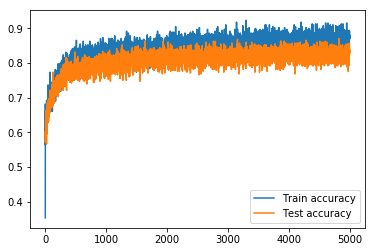

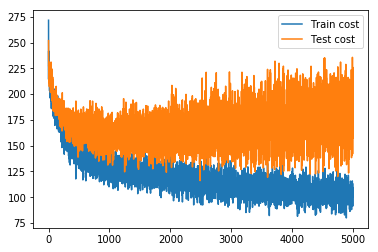

In [2]:
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()

In [3]:
min(perf_collect[3]), max(perf_collect[3]), sum(perf_collect[3])/len(perf_collect[3])

(0.5657894611358643, 0.871052622795105, 0.8058226315140724)

In [5]:
len(perf_collect[3])

5000

In [11]:
aux = []
aux2 = []

for i in range(len(perf_collect[3])):
    if i%10 == 0:
        aux.append(perf_collect[3][i])
        aux2.append(perf_collect[2][i])

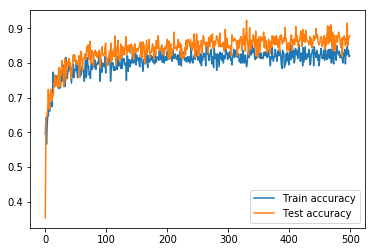

In [12]:
plt.figure()
plt.plot(aux,label = 'Train accuracy')
plt.plot(aux2,label = 'Test accuracy')
plt.legend()
plt.show()